# Variable-speed synfire chains

Conductance-based LIF network:

$$C_m^i \frac{dv^i}{dt} = g_l[E_l^i - V^i(t)] + g^i_e(t)[E_e - V^i(t)] + g^i_i(t)[E_i - V^i(t)] + I^i_{ext}(t)$$

The time-varying conductances $g^i_e$ and $g^i_i$ are exponentially filtered sums of spike trains from upstream neurons $j$, with time constants $\tau_e$ and $\tau_i$ and weighted by $W_e^{ij}$ and $W_i^{ij}$ respectively.

All param values are in SI units, with capacitance and conductance per cm$^2$.

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, stats

from aux import Generic
from disp import set_font_size, get_spaced_colors
from ntwk import LIFNtwkG, join_w

cc = np.concatenate

# PARAMS
## BASE MODEL
M = {
    # E membrane
    'C_M_E': 1e-6, 'G_L_E': .1e-3,  # T_M (s) = C_M (F/cm^2) / G_L (S/cm^2)
    'E_L_E': -0.06, 'V_TH_E': -0.05, 'V_R_E': -0.06, 'T_R_E': 0.002,
    
    # I membrane
    'C_M_I': 1e-6, 'G_L_I': .2e-3,  # T_M = C_M_/G_L
    'E_L_I': -0.06, 'V_TH_I': -0.05, 'V_R_I': -0.06, 'T_R_I': 0.002,
    
    # syn rev potentials & time constants
    'E_E': 0, 'E_I': -0.08, 'T_E': 0.002, 'T_I': 0.002,
    
    # architecture
    'N_L': 100,  # num links
    'N_L_E': 30,  # num E nrns in chain link
    'W_E_E_R': 0.005e-3,  # E->E recurrent cxns w/in link
    'W_E_E_F': 0.01e-3,  # E->E feed-forward cxns btwn links
    'W_U_E_I': 0.05e-3,  # I->E input weights
    'T_R_E': 1,  # extra long refrac period (s)
    'SGM_N': .5e-9,  # A*sqrt(s)
    
    # modulatory control
    'V_F': 1.2, 'W': 0.5, 'H': 0.5, 'T_P_CH': 0.02,
}

## SMLN
S = {
    'RNG_SEED': 0, 'DT': .0005, 'T': 0.15,
}

print('T_M_E =', 1000*M['C_M_E']/M['G_L_E'], 'ms')
print('T_M_I =', 1000*M['C_M_I']/M['G_L_I'], 'ms')

T_M_E = 10.0 ms
T_M_I = 5.0 ms


# Spatiotemporally modulated spike sequence

In [2]:
# set up modulatory signal

def to_ch_units(v_f_ch, v_s_ch, v_f, w, h, t_p_ch):
    """Convert unitless params to units of chain links and seconds.
    
    :param v_f_ch: fast chain speed (links/sec)
    :param v_s_ch: slow chian speed (links/sec)
    :param v_f: fast speed (unitless)
    :param w: temporal czone width (btwn 0 and 1)
    :param h: spatial czone width (btwn 0 and 1)
    :param t_p_ch: temporal chain period (sec)
    
    """
    v_ch = v_f_ch / v_f  # stable speed in chain links / sec
    x_p_ch = v_ch * t_p_ch  # spatial period in chain links
    w_ch = t_p_ch * w
    h_ch = x_p_ch * h
    
    v_s = v_f * (v_s_ch/v_f_ch)
    
    print('v_ch = {0:.3f} links/s'.format(v_ch))
    print('x_p_ch = {0:.3f} links'.format(x_p_ch))
    print('t_p_ch = {0:.3f} s'.format(t_p_ch))
    print('w_ch = {0:.3f} s'.format(w_ch))
    print('h_ch = {0:.3f} links'.format(h_ch))
    
    return Generic(
        v_f=v_f, v_s=v_s, w=w, h=h,
        v_f_ch=v_f_ch, v_s_ch=v_s_ch, v_ch=v_ch, x_p_ch=x_p_ch, t_p_ch=t_p_ch, w_ch=w_ch, h_ch=h_ch)

ctl_prm = to_ch_units(
    v_f_ch=1165, v_s_ch=570, v_f=M['V_F'], w=M['W'], h=M['H'], t_p_ch=M['T_P_CH'])

def plot_czone(ctl_prm, figsize=(12, 10)):
    
    t = np.arange(0, S['T'], S['DT'])
    x = np.arange(0, M['N_L'], .01)

    a = .5 * (signal.square((2*np.pi/ctl_prm.t_p_ch)*t, ctl_prm.w) + 1)
    b = .5 * (signal.square((2*np.pi/ctl_prm.x_p_ch)*x, ctl_prm.h) + 1)

    gs = gridspec.GridSpec(6, 6)
    fig = plt.figure(figsize=figsize, tight_layout=True)
    axs = [fig.add_subplot(gs[0, :-1]), fig.add_subplot(gs[1:, -1]), fig.add_subplot(gs[1:, :-1])]

    axs[0].plot(t, a, c='b', lw=2)
    axs[0].fill_between(t, np.zeros(len(a)), a, color='b', alpha=.3)
    axs[0].set_xlim(0, S['T'])
    axs[0].set_ylim(-.1, 1.1)

    axs[0].set_xticks([])
    axs[0].set_yticks([0, 1])
    axs[0].set_xlabel('Temporal modulation: a(t)', color='b')
    axs[0].xaxis.set_label_position('top') 

    axs[1].plot(b, x, c='r', lw=2)
    axs[1].fill_betweenx(x, np.zeros(len(x)), b, color='r', alpha=.3)
    axs[1].set_ylim(0, M['N_L'])
    axs[1].set_xlim(-.1, 1.1)

    axs[1].set_yticks([])
    axs[1].set_xticks([0, 1])
    axs[1].set_ylabel('Spatial modulation: b(x)', color='r')
    axs[1].yaxis.set_label_position('right')

    for t_ in np.arange(0, S['T'], ctl_prm.t_p_ch):
        for x_ in np.arange(0, M['N_L'], ctl_prm.x_p_ch):
            axs[2].fill_between(
                [t_, t_+ctl_prm.w_ch], [x_]*2, [x_+ctl_prm.h_ch]*2,
                color='violet', alpha=.3, zorder=0)

    axs[2].set_xlim(0, S['T'])
    axs[2].set_ylim(0, M['N_L'])
    axs[2].set_xlabel('t (s)')
    axs[2].set_ylabel('x (link)')

    for ax in axs:
        set_font_size(ax, 16)
        
    return axs

v_ch = 970.833 links/s
x_p_ch = 19.417 links
t_p_ch = 0.020 s
w_ch = 0.010 s
h_ch = 9.708 links


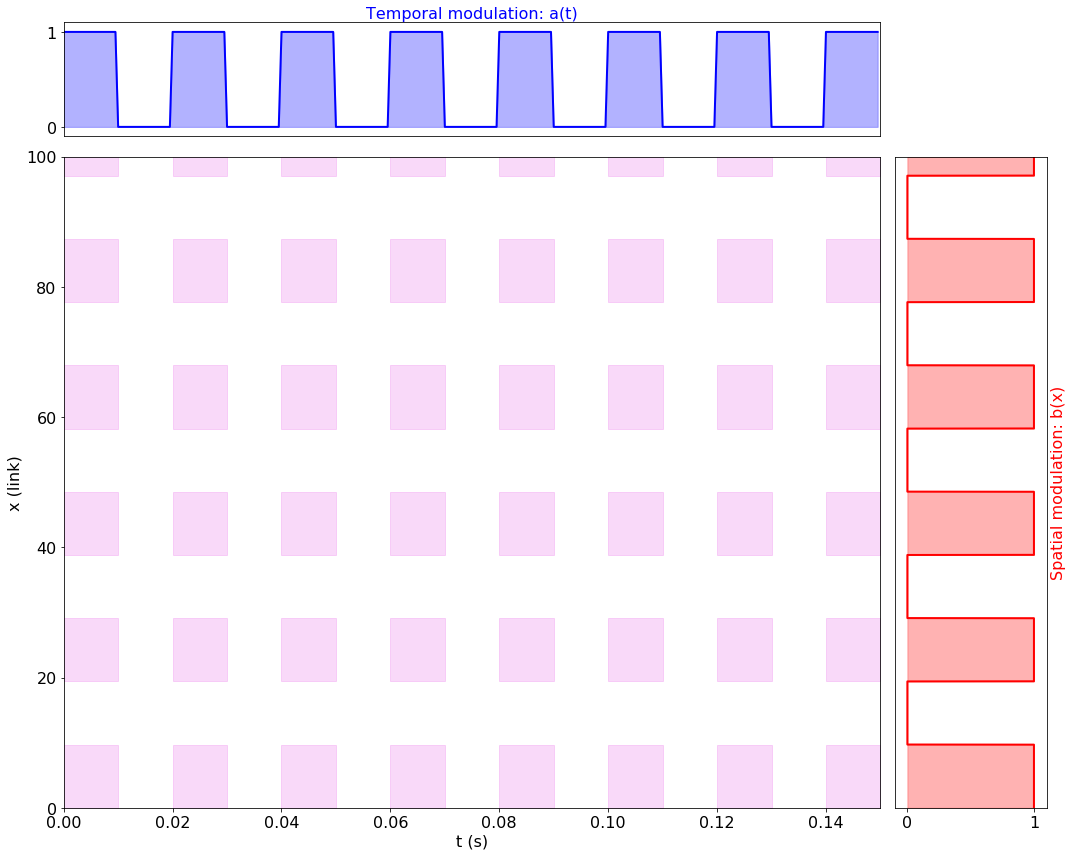

In [3]:
plot_czone(ctl_prm, figsize=(15, 12));